In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_default_tensor_type('torch.DoubleTensor')
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

import utils
import mlmodel

import sys
if sys.platform == 'win32':
    NUM_WORKERS = 0 # Windows does not support multiprocessing
else:
    NUM_WORKERS = 2
print('running on ' + sys.platform + ', setting ' + str(NUM_WORKERS) + ' workers')

running on win32, setting 0 workers


In [5]:
dim_a = 3
features = ['v', 'q', 'pwm']
label = 'fa'
WIN = 30

# Training data collected from the neural-fly drone
dataset = 'neural-fly' 
dataset_folder = 'data/training'
hover_pwm_ratio = 1.
modelname = f"{dataset}_dim-a-{dim_a}_{'-'.join(features)}"  # 'neural-fly_dim-a-3_v-q-pwm'
# print(modelname)

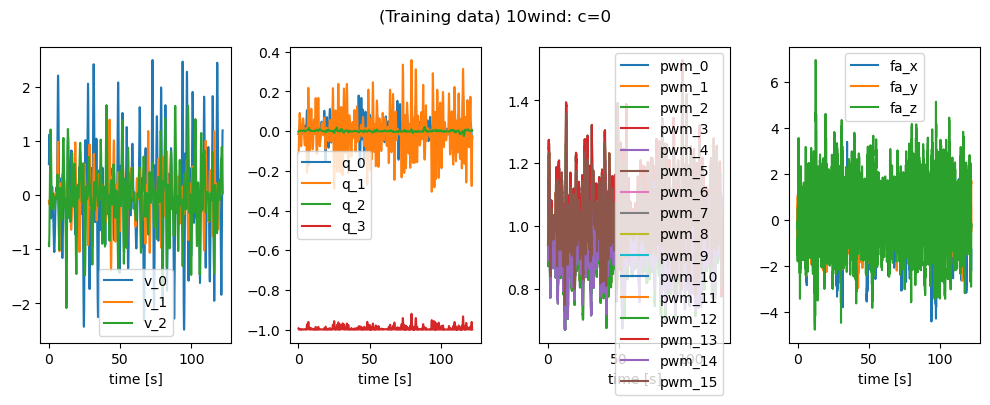

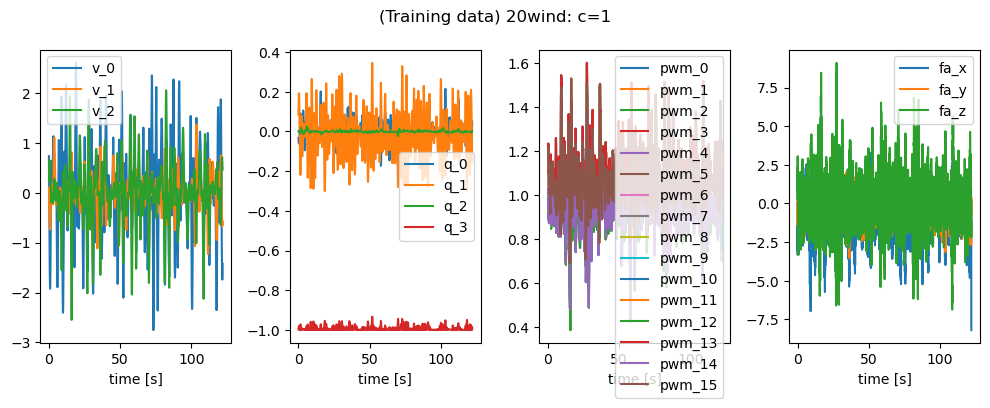

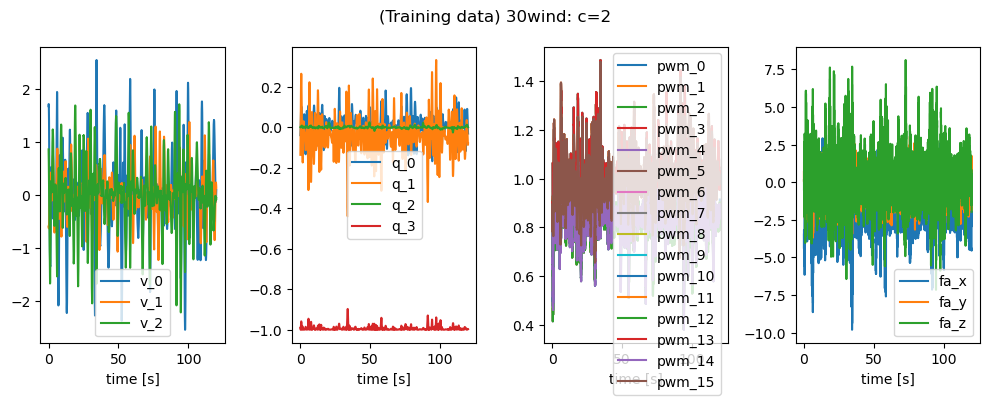

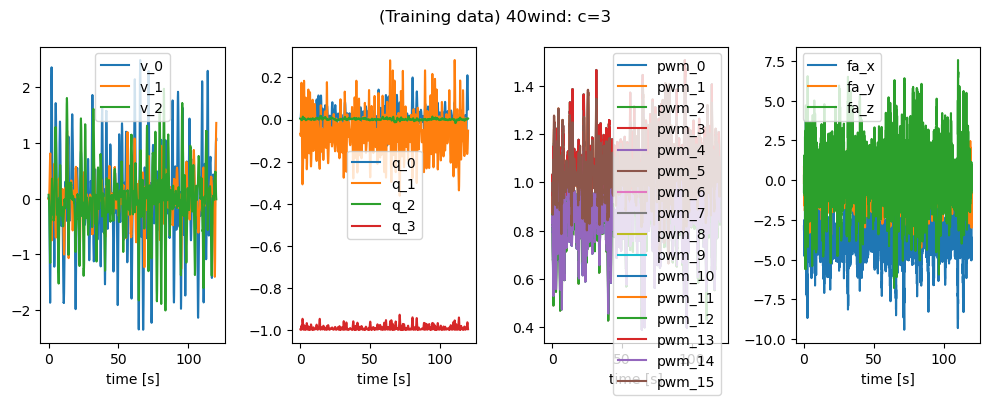

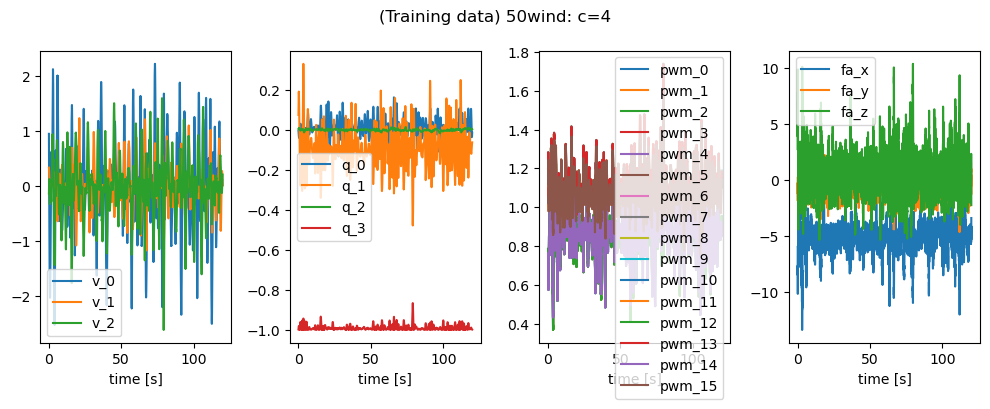

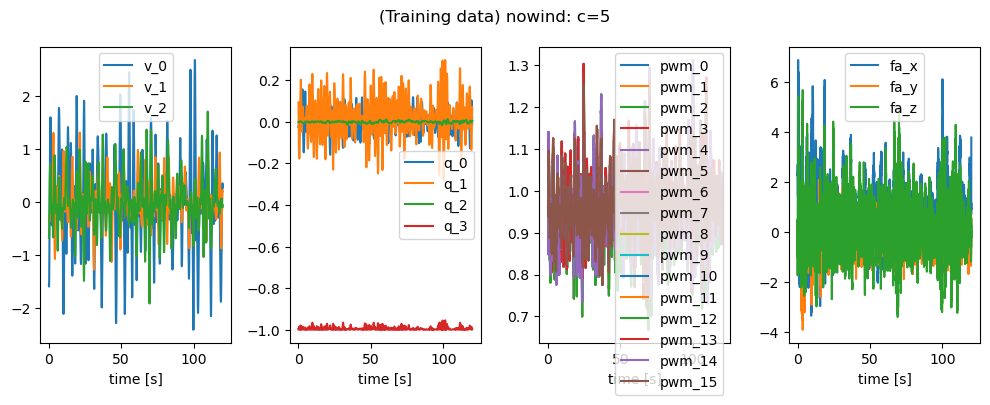

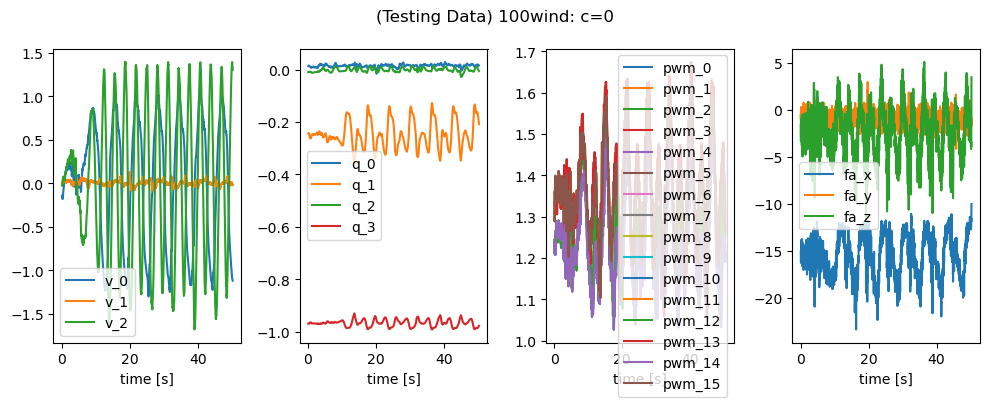

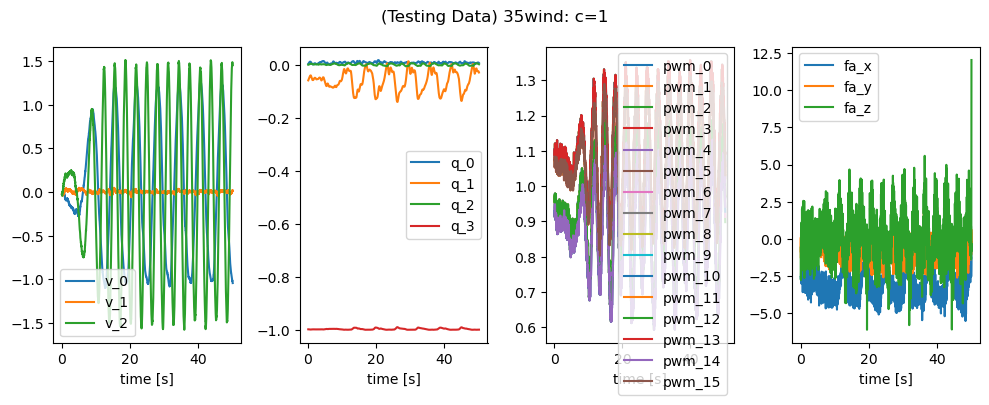

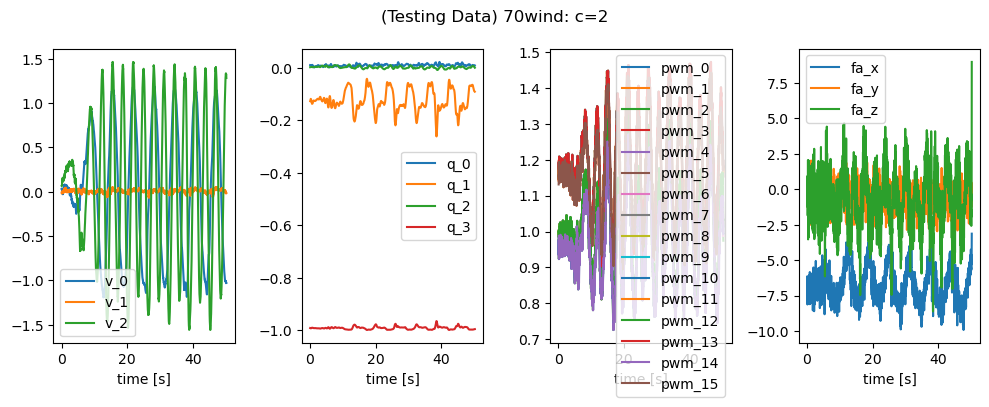

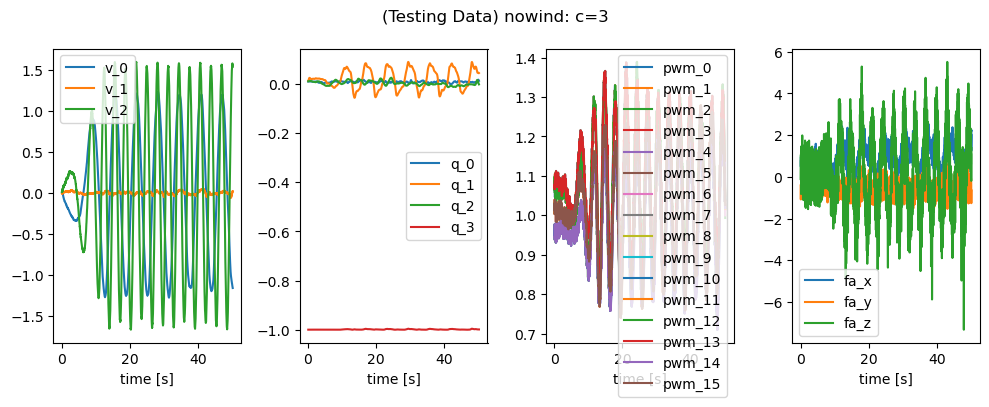

In [6]:
# RawData = utils.load_data(dataset_folder)
# # Data = utils.format_data(RawData, features=features, output=label)
# Data = utils.format_data(RawData, features=features, output=label, smooth_win=WIN)
# 
# testdata_folder = 'data/experiment'
# RawData = utils.load_data(testdata_folder, expnames='(baseline_)([0-9]*|no)wind')
# # TestData = utils.format_data(RawData, features=features, output=label, hover_pwm_ratio=hover_pwm_ratio)
# TestData = utils.format_data(RawData, features=features, output=label,
#                              hover_pwm_ratio=hover_pwm_ratio, smooth_win=WIN)
WIN = 1          # 你认为原始数据没问题，就先不平滑
K_DELAY = 3      # 3步延迟（60ms @ 50Hz）

RawData = utils.load_data(dataset_folder)
Data = utils.format_data(RawData, features=features, output=label,
                         hover_pwm_ratio=1.0,
                         smooth_win=WIN,
                         pwm_delay_steps=K_DELAY)

testdata_folder = 'data/experiment'
RawData = utils.load_data(testdata_folder, expnames='(baseline_)([0-9]*|no)wind')
TestData = utils.format_data(RawData, features=features, output=label,
                             hover_pwm_ratio=hover_pwm_ratio,
                             smooth_win=WIN,
                             pwm_delay_steps=K_DELAY)
# sd = Data[0]
# print(sd.X.shape, sd.Y.shape)
# # 应该满足：sd.X.shape[0] == sd.Y.shape[0] == 原T - 3

for data in Data:
    utils.plot_subdataset(data, features, title_prefix="(Training data)")

for data in TestData:
    utils.plot_subdataset(data, features, title_prefix="(Testing Data)")

In [7]:
options = {}
options['dim_x'] = Data[0].X.shape[1]
options['dim_y'] = Data[0].Y.shape[1]
options['num_c'] = len(Data)
print('dims of (x, y) are', (options['dim_x'], options['dim_y']))
print('there are ' + str(options['num_c']) + ' different conditions')
# dims of (x, y) are (11, 3)
# there are 6 different conditions

dims of (x, y) are (23, 3)
there are 6 different conditions


In [8]:
# Set hyperparameters
options['features'] = features
options['dim_a'] = dim_a
options['loss_type'] = 'crossentropy-loss'

options['shuffle'] = True # True: shuffle trajectories to data points
options['K_shot'] = 32 # number of K-shot for least square on a
options['phi_shot'] = 256 # batch size for training phi

options['alpha'] = 0.01 # adversarial regularization loss
options['learning_rate'] = 5e-4
options['frequency_h'] = 2 # how many times phi is updated between h updates, on average
options['SN'] = 2. # maximum single layer spectral norm of phi
options['gamma'] = 10. # max 2-norm of a
options['num_epochs'] = 1000

In [9]:
Trainloader = []
Adaptloader = []
for i in range(options['num_c']):
    fullset = mlmodel.MyDataset(Data[i].X, Data[i].Y, Data[i].C)
    
    l = len(Data[i].X)
    if options['shuffle']:
        trainset, adaptset = random_split(fullset, [int(2/3*l), l-int(2/3*l)])
    else:
        trainset = mlmodel.MyDataset(Data[i].X[:int(2/3*l)], Data[i].Y[:int(2/3*l)], Data[i].C) 
        adaptset = mlmodel.MyDataset(Data[i].X[int(2/3*l):], Data[i].Y[int(2/3*l):], Data[i].C)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=options['phi_shot'], shuffle=options['shuffle'], num_workers=NUM_WORKERS)
    adaptloader = torch.utils.data.DataLoader(adaptset, batch_size=options['K_shot'], shuffle=options['shuffle'], num_workers=NUM_WORKERS)
   
    # Trainset.append(trainset)
    # Adaptset.append(adaptset)
    Trainloader.append(trainloader) # for training phi
    Adaptloader.append(adaptloader) # for LS on a

In [10]:
# Store the model class definition in an external file so they can be referenced outside this script
phi_net = mlmodel.Phi_Net(options)
h_net = mlmodel.H_Net_CrossEntropy(options)
criterion = nn.MSELoss()
criterion_h = nn.CrossEntropyLoss()
optimizer_h = optim.Adam(h_net.parameters(), lr=options['learning_rate'])
optimizer_phi = optim.Adam(phi_net.parameters(), lr=options['learning_rate'])

In [11]:
model_save_freq = 50 # How often to save the model

# Create some arrays to save training statistics
Loss_f = [] # combined force prediction loss
Loss_c = [] # combined adversarial loss

# Loss for each subdataset 
Loss_test_nominal = [] # loss without any learning
Loss_test_mean = [] # loss with mean predictor
Loss_test_phi = [] # loss with NN
for i in range(len(TestData)):
    Loss_test_nominal.append([])
    Loss_test_mean.append([])
    Loss_test_phi.append([])

# Training!
for epoch in range(options['num_epochs']):
    # Randomize the order in which we train over the subdatasets
    arr = np.arange(options['num_c'])
    np.random.shuffle(arr)

    # Running loss over all subdatasets
    running_loss_f = 0.0
    running_loss_c = 0.0

    for i in arr:
        with torch.no_grad():
            adaptloader = Adaptloader[i]
            kshot_data = next(iter(adaptloader))
            trainloader = Trainloader[i]
            data = next(iter(trainloader))
        
        optimizer_phi.zero_grad()
        
        '''
        Least-square to get $a$ from K-shot data
        '''
        X = kshot_data['input'] # K x dim_x
        Y = kshot_data['output'] # K x dim_y
        Phi = phi_net(X) # K x dim_a
        Phi_T = Phi.transpose(0, 1) # dim_a x K
        A = torch.inverse(torch.mm(Phi_T, Phi)) # dim_a x dim_a
        a = torch.mm(torch.mm(A, Phi_T), Y) # dim_a x dim_y
        if torch.norm(a, 'fro') > options['gamma']:
            a = a / torch.norm(a, 'fro') * options['gamma']
            
        '''
        Batch training \phi_net
        '''
        inputs = data['input'] # B x dim_x
        labels = data['output'] # B x dim_y
        
        c_labels = data['c'].type(torch.long)
            
        # forward + backward + optimize
        outputs = torch.mm(phi_net(inputs), a)
        loss_f = criterion(outputs, labels)
        temp = phi_net(inputs)
        
        loss_c = criterion_h(h_net(temp), c_labels)
            
        loss_phi = loss_f - options['alpha'] * loss_c
        loss_phi.backward()
        optimizer_phi.step()
        
        '''
        Discriminator training
        '''
        if np.random.rand() <= 1.0 / options['frequency_h']:
            optimizer_h.zero_grad()
            temp = phi_net(inputs)
            
            loss_c = criterion_h(h_net(temp), c_labels)
            
            loss_h = loss_c
            loss_h.backward()
            optimizer_h.step()
        
        '''
        Spectral normalization
        '''
        if options['SN'] > 0:
            for param in phi_net.parameters():
                M = param.detach().numpy()
                if M.ndim > 1:
                    s = np.linalg.norm(M, 2)
                    if s > options['SN']:
                        param.data = param / s * options['SN']
         
        running_loss_f += loss_f.item()
        running_loss_c += loss_c.item()
    
    # Save statistics
    Loss_f.append(running_loss_f / options['num_c'])
    Loss_c.append(running_loss_c / options['num_c'])
    if epoch % 10 == 0:
        print('[%d] loss_f: %.2f loss_c: %.2f' % (epoch + 1, running_loss_f / options['num_c'], running_loss_c / options['num_c']))

        
    with torch.no_grad():
        for j in range(len(TestData)):
            loss_nominal, loss_mean, loss_phi = mlmodel.error_statistics(TestData[j].X, TestData[j].Y, phi_net, h_net, options=options)
            Loss_test_nominal[j].append(loss_nominal)
            Loss_test_mean[j].append(loss_mean)
            Loss_test_phi[j].append(loss_phi)

    if epoch % model_save_freq == 0:
        mlmodel.save_model(phi_net=phi_net, h_net=h_net, modelname=modelname + '-epoch-' + str(epoch), options=options)

[1] loss_f: 3.98 loss_c: 1.81
[11] loss_f: 1.68 loss_c: 1.81
[21] loss_f: 1.41 loss_c: 1.81
[31] loss_f: 1.32 loss_c: 1.80
[41] loss_f: 1.16 loss_c: 1.80
[51] loss_f: 1.13 loss_c: 1.80
[61] loss_f: 0.94 loss_c: 1.80
[71] loss_f: 1.07 loss_c: 1.81
[81] loss_f: 1.06 loss_c: 1.80
[91] loss_f: 0.97 loss_c: 1.80
[101] loss_f: 0.87 loss_c: 1.80
[111] loss_f: 0.85 loss_c: 1.80
[121] loss_f: 0.84 loss_c: 1.80
[131] loss_f: 0.83 loss_c: 1.80
[141] loss_f: 0.84 loss_c: 1.80
[151] loss_f: 0.84 loss_c: 1.80
[161] loss_f: 0.87 loss_c: 1.80
[171] loss_f: 0.83 loss_c: 1.79
[181] loss_f: 0.83 loss_c: 1.80
[191] loss_f: 0.79 loss_c: 1.80
[201] loss_f: 0.86 loss_c: 1.80
[211] loss_f: 0.93 loss_c: 1.79
[221] loss_f: 0.81 loss_c: 1.80
[231] loss_f: 0.81 loss_c: 1.80
[241] loss_f: 0.80 loss_c: 1.79
[251] loss_f: 0.84 loss_c: 1.80
[261] loss_f: 0.77 loss_c: 1.79
[271] loss_f: 0.77 loss_c: 1.79
[281] loss_f: 0.79 loss_c: 1.79
[291] loss_f: 0.76 loss_c: 1.79
[301] loss_f: 0.75 loss_c: 1.79
[311] loss_f: 0.75 

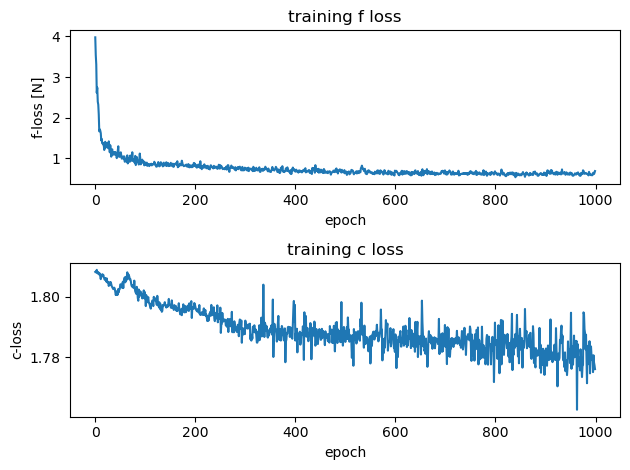

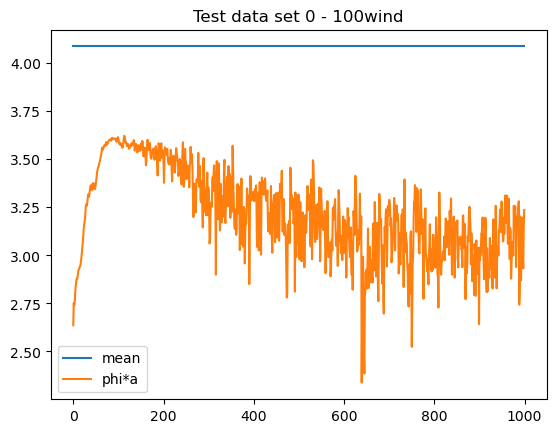

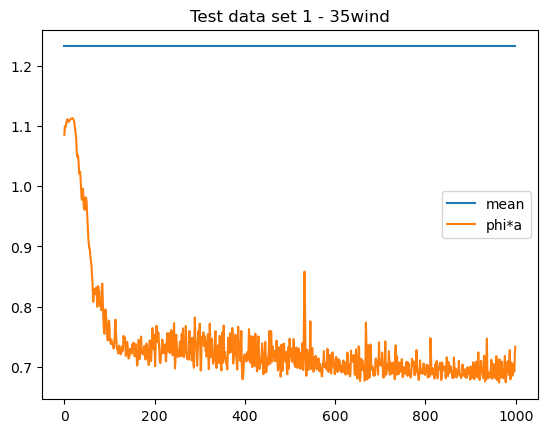

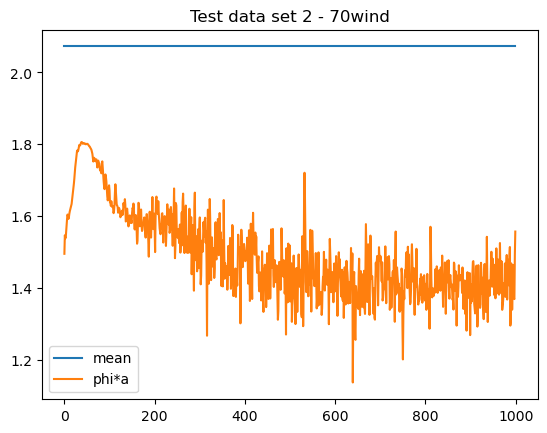

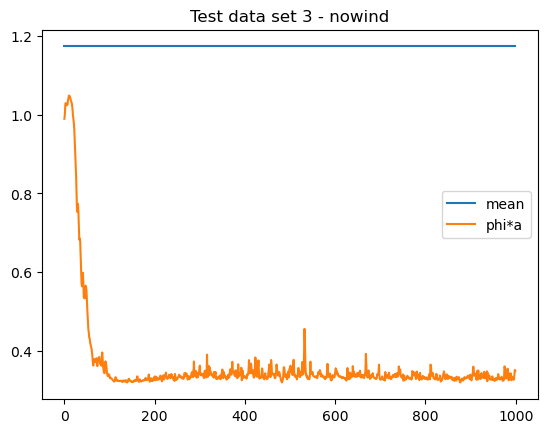

In [12]:
plt.subplot(2, 1, 1)
plt.plot(Loss_f)
plt.xlabel('epoch')
plt.ylabel('f-loss [N]')
plt.title('training f loss')
plt.subplot(2, 1, 2)
plt.plot(Loss_c)
plt.title('training c loss')
plt.xlabel('epoch')
plt.ylabel('c-loss')
plt.tight_layout()

for j in range(len(TestData)):
    plt.figure()
    # plt.plot(Loss_test_nominal[j], label='nominal')
    plt.plot(Loss_test_mean[j], label='mean')
    plt.plot(np.array(Loss_test_phi[j]), label='phi*a')
    # plt.plot(np.array(Loss_test_exp_forgetting[j]), label='exp forgetting')
    plt.legend()
    plt.title(f'Test data set {j} - {TestData[j].meta["condition"]}')

plt.show()

In [13]:
# Choose final model
stopping_epoch = 950
options['num_epochs'] = stopping_epoch
final_model = mlmodel.load_model(modelname = modelname + '-epoch-' + str(stopping_epoch))

------------------------------
10wind:
a = [[ 3.8402601  -0.61618162  3.61665163]
 [ 2.1797126  -0.26158369 -5.17938563]
 [ 2.22332063 -0.72528815  0.20502366]]
|a| = 8.084818318114278


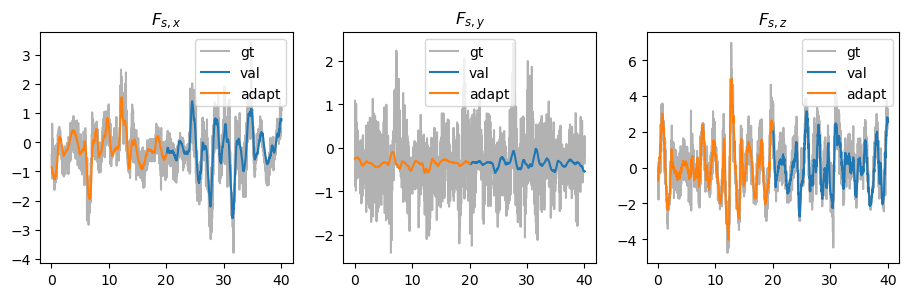

------------------------------
20wind:
a = [[ 4.85490622 -0.11082051  3.46978894]
 [ 2.73800546 -0.2418792  -5.13469381]
 [ 2.0348215  -0.6319994  -0.09039591]]
|a| = 8.60756551190878


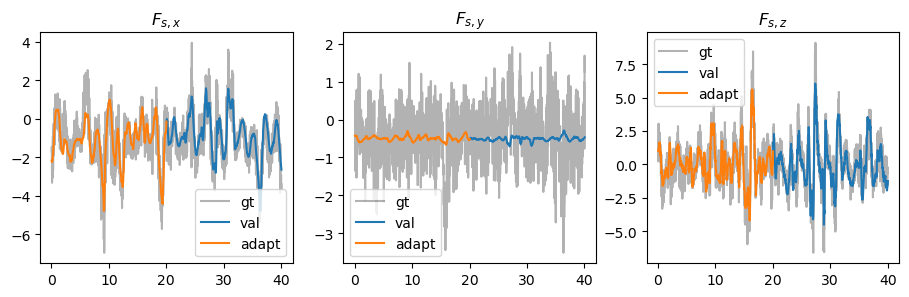

------------------------------
30wind:
a = [[ 5.64425723 -0.166479    3.11908669]
 [ 3.11082656  0.25816211 -6.13375974]
 [ 1.16329842 -0.32414245  0.76970339]]
|a| = 9.541054953449313


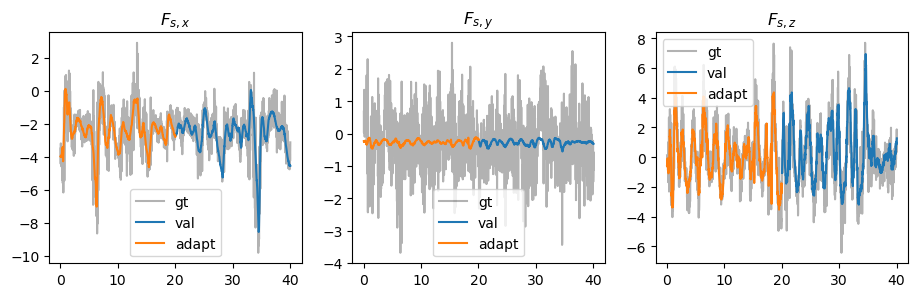

------------------------------
40wind:
a = [[ 5.80267738 -1.71953389  2.00272952]
 [ 2.54716265 -0.71197858 -6.47500413]
 [-0.37595419 -1.34851351 -0.09083574]]
|a| = 9.567000470904631


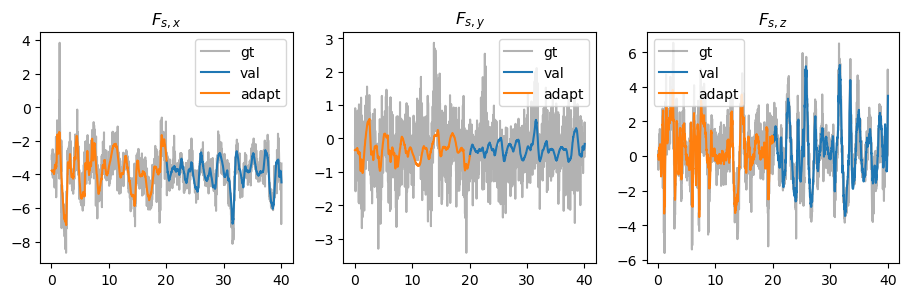

------------------------------
50wind:
a = [[ 6.2317926  -0.02060745  1.20233498]
 [ 2.9380111   0.45198417 -6.90629674]
 [-1.66755758 -0.37274845 -0.54456791]]
|a| = 10.001532410836564


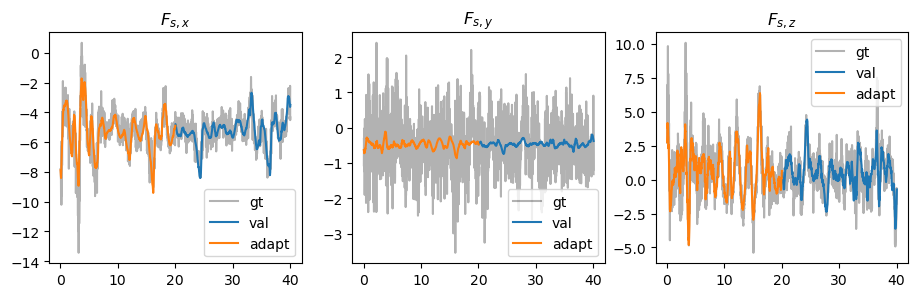

------------------------------
nowind:
a = [[ 5.74261689 -1.78394339  4.4858262 ]
 [ 2.49916123 -0.45563972 -4.85637125]
 [ 4.67148553 -1.29303     1.34413767]]
|a| = 10.565126845906116


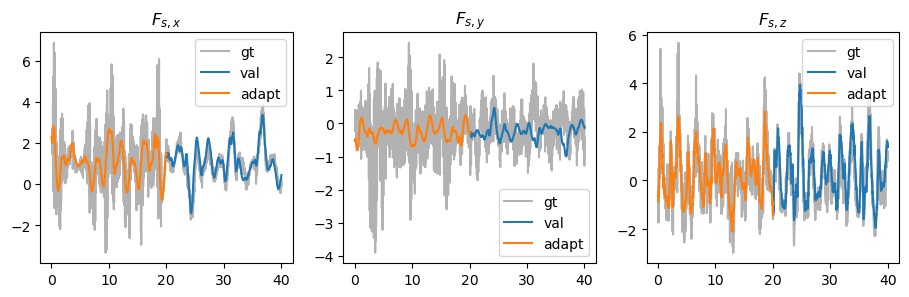

In [14]:
for i, data in enumerate(Data):
    print('------------------------------')
    print(data.meta['condition'] + ':')
    mlmodel.vis_validation(t=data.meta['t'], x=data.X, y=data.Y, phi_net=final_model.phi, h_net=final_model.h, idx_adapt_start=0, idx_adapt_end=1000, idx_val_start=1000, idx_val_end=2000, c=Data[i].C, options=options)

In [15]:
for data in Data:
    error_1, error_2, error_3 = mlmodel.error_statistics(data.X, data.Y, final_model.phi, final_model.h, options=options)
    print('**** c =', str(data.C), ':', data.meta['condition'], '****')
    print(f'Before learning: MSE is {error_1: .2f}')
    print(f'Mean predictor: MSE is {error_2: .2f}')
    print(f'After learning phi(x): MSE is {error_3: .2f}')
    print('')

**** c = 0 : 10wind ****
Before learning: MSE is  1.20
Mean predictor: MSE is  1.13
After learning phi(x): MSE is  0.35

**** c = 1 : 20wind ****
Before learning: MSE is  2.17
Mean predictor: MSE is  1.67
After learning phi(x): MSE is  0.54

**** c = 2 : 30wind ****
Before learning: MSE is  3.57
Mean predictor: MSE is  1.75
After learning phi(x): MSE is  0.68

**** c = 3 : 40wind ****
Before learning: MSE is  6.69
Mean predictor: MSE is  1.91
After learning phi(x): MSE is  0.65

**** c = 4 : 50wind ****
Before learning: MSE is  11.41
Mean predictor: MSE is  2.03
After learning phi(x): MSE is  0.74

**** c = 5 : nowind ****
Before learning: MSE is  1.26
Mean predictor: MSE is  0.85
After learning phi(x): MSE is  0.30



------------------------------
100wind:
a = [[  5.13875714  -0.26531786  -2.73441816]
 [  0.9379885    0.32471598  -8.83230743]
 [-14.84396295  -0.74403716  -6.8315822 ]]
|a| = 19.506832686643467


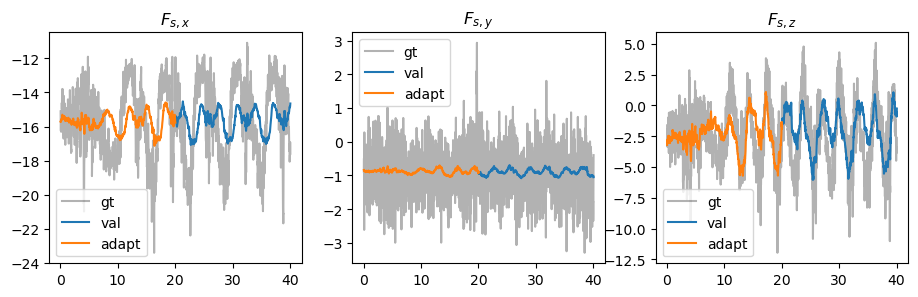

------------------------------
35wind:
a = [[ 5.00581725 -0.04441097  1.15591709]
 [ 2.95343028  0.11919572 -4.48048392]
 [ 0.01453558 -0.42256089 -0.59511369]]
|a| = 7.465985968029543


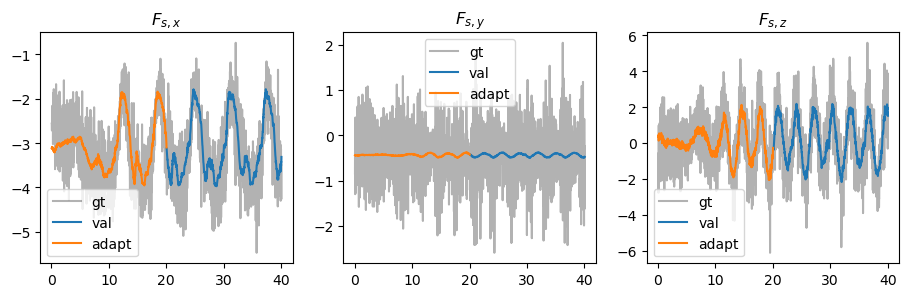

------------------------------
70wind:
a = [[ 5.98477385e+00 -2.21599408e-03  2.39361707e-01]
 [ 3.65230334e+00  2.20411628e-01 -5.16139960e+00]
 [-3.12861014e+00 -3.31416002e-01 -2.35242088e+00]]
|a| = 9.55691821499218


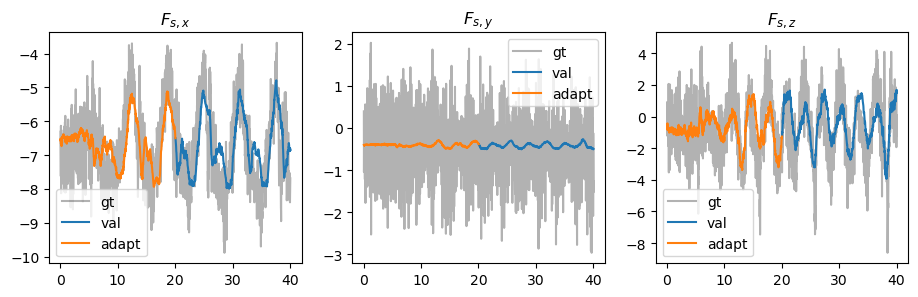

------------------------------
nowind:
a = [[ 3.7289495   0.12325516  4.56441414]
 [ 1.77935745  0.28067022 -4.1202116 ]
 [ 3.15176628 -0.32763789  0.67705754]]
|a| = 8.091634519817472


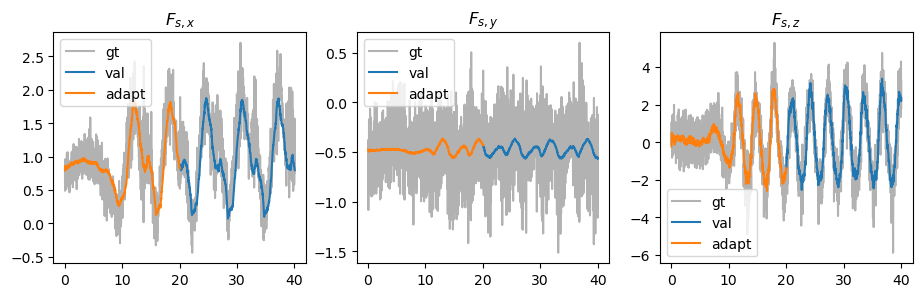

In [16]:
for i, data in enumerate(TestData):
    print('------------------------------')
    print(data.meta['condition'] + ':')
    mlmodel.vis_validation(t=data.meta['t'], x=data.X, y=data.Y, phi_net=final_model.phi, h_net=final_model.h, idx_adapt_start=0, idx_adapt_end=1000, idx_val_start=1000, idx_val_end=2000, c=Data[i].C, options=options)

In [17]:
for data in TestData:
    error_1, error_2, error_3 = mlmodel.error_statistics(data.X, data.Y, final_model.phi, final_model.h, options=options)
    print('**** :', data.meta['condition'], '****')
    print(f'Before learning: MSE is {error_1: .2f}')
    print(f'Mean predictor: MSE is {error_2: .2f}')
    print(f'After learning phi(x): MSE is {error_3: .2f}')
    print('')

**** : 100wind ****
Before learning: MSE is  87.64
Mean predictor: MSE is  4.09
After learning phi(x): MSE is  3.18

**** : 35wind ****
Before learning: MSE is  4.61
Mean predictor: MSE is  1.23
After learning phi(x): MSE is  0.69

**** : 70wind ****
Before learning: MSE is  17.83
Mean predictor: MSE is  2.07
After learning phi(x): MSE is  1.43

**** : nowind ****
Before learning: MSE is  1.59
Mean predictor: MSE is  1.17
After learning phi(x): MSE is  0.33

